In [1]:
# import dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import matplotlib.transforms as mtransforms
from STalign import STalign
from matplotlib.colors import ListedColormap

# make plots bigger
plt.rcParams["figure.figsize"] = (12,10)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# i/o
work_dir = '.'

img_path = work_dir + '/data/HE_allen_brain_atlas/60_100142143_289.jpg'
df_path = work_dir + '/data/Puck_200115_08_bead_locations.csv' # Slide-seq bead coordinates

In [3]:
# import data
img = plt.imread(img_path)
df = pd.read_csv(df_path, header=None, skiprows=1, index_col=0)
leiden = pd.read_csv(leiden_path, header=None, skiprows=1, index_col=0)

In [4]:
print(img.shape)
print(img.min())
print(img.max())

(1004, 1690, 3)
0
255


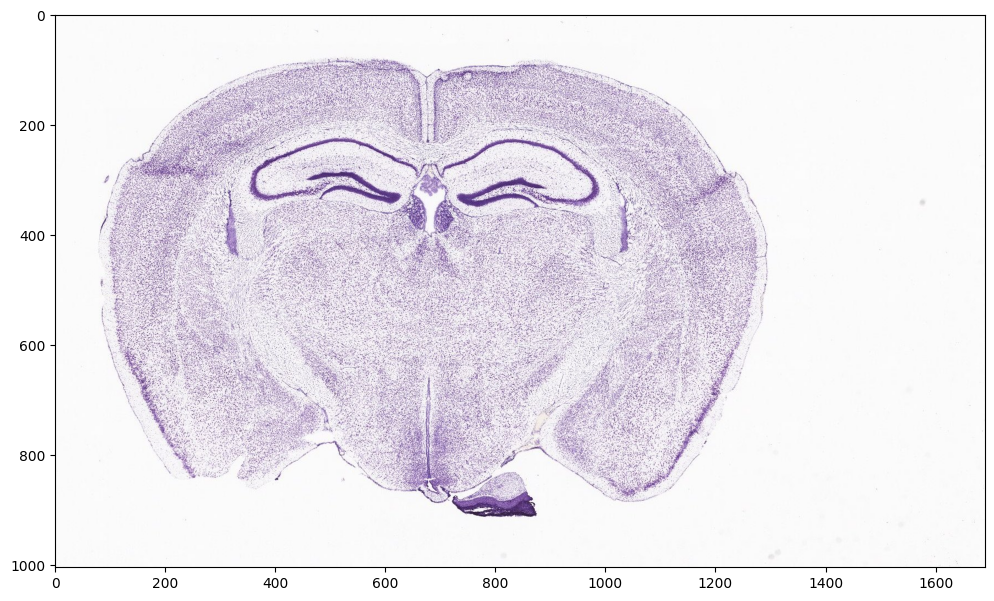

In [5]:
fig,ax = plt.subplots()
ax.imshow(img)

In [6]:
img_norm = STalign.normalize(img)

print(img_norm.min())
print(img_norm.max())


0.0
1.0


In [7]:
img_t = img_norm.transpose(2,0,1)
print(img_t.shape)

imgy = np.array(range(img_t.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
imgx = np.array(range(img_t.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
extent_img = STalign.extent_from_x((imgy,imgx))

(3, 1004, 1690)


In [8]:
print("The initial shape of img is {}".format(img_t.shape))
print("The range of img is {} to {}".format(img_t.min(), img_t.max() ))


The initial shape of img is (3, 1004, 1690)
The range of img is 0.0 to 1.0


In [9]:
df.columns = ['xcoord', 'ycoord']
df['cluster'] = leiden
df['cluster_codes'] = pd.Categorical(df['cluster']).codes

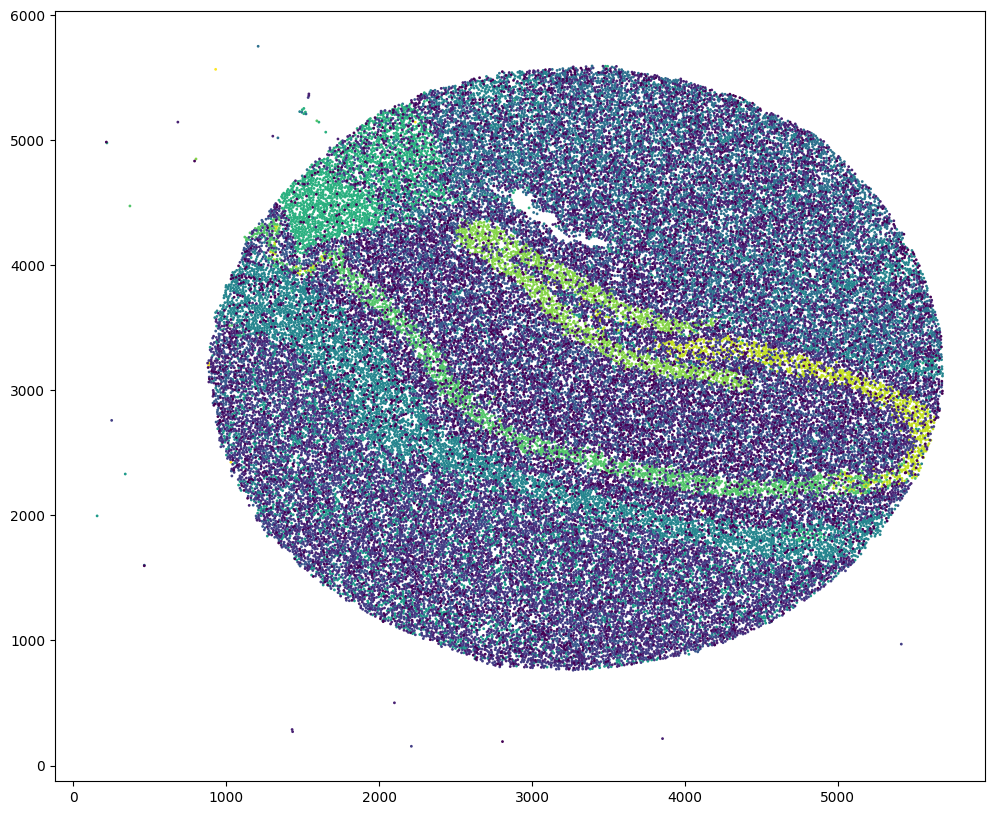

In [10]:
spx = np.array(df['xcoord'])
spy = np.array(df['ycoord'])

# plot
fig,ax = plt.subplots()
ax.scatter(df['xcoord'], df['ycoord'], s=1, c=df['cluster_codes'])

0 of 53208
10000 of 53208
20000 of 53208
30000 of 53208
40000 of 53208
50000 of 53208
53207 of 53208


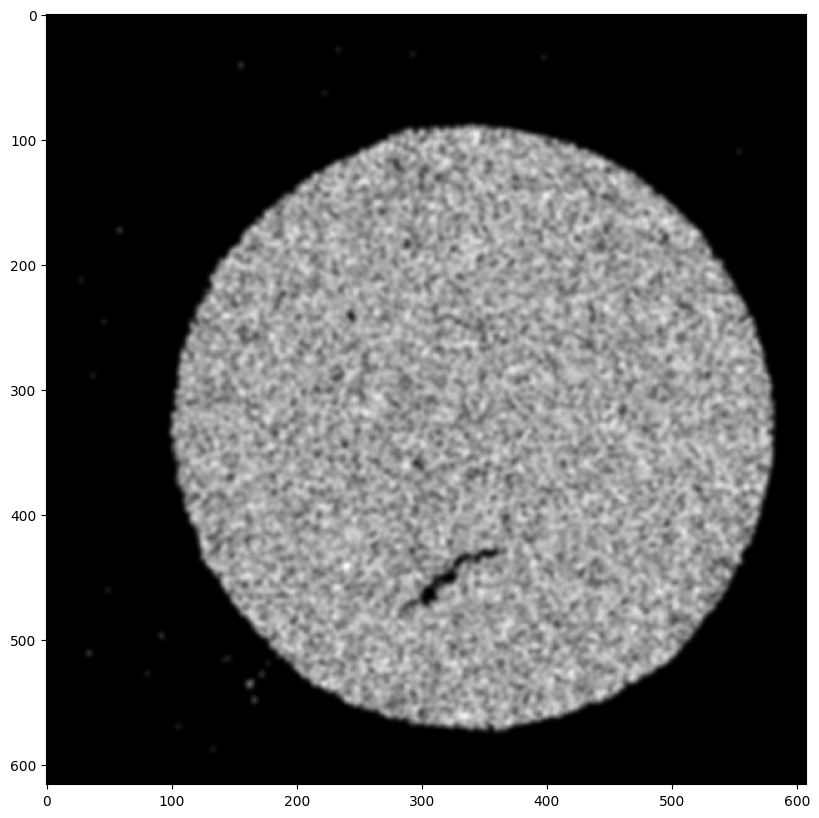

In [12]:
spx,spy,sp,fig = STalign.rasterize(df['xcoord'], df['ycoord'], dx=10, blur=1)

In [13]:
print("The initial shape of sp is {}".format(sp.shape))
sp = np.vstack((sp, sp, sp)) # make into 3xNxM
print("The range of sp is {} to {}".format(sp.min(), sp.max() ))

# normalize
sp = STalign.normalize(sp)
print("The range of I after normalization is {} to {}".format(sp.min(), sp.max() ))

# double check size of things
print("The new shape of sp is {}".format(sp.shape))

The initial shape of sp is (1, 616, 608)
The range of sp is 0.0 to 0.4696663582090354
The range of I after normalization is 0.0 to 1.0
The new shape of sp is (3, 616, 608)


Text(0.5, 1.0, 'target')

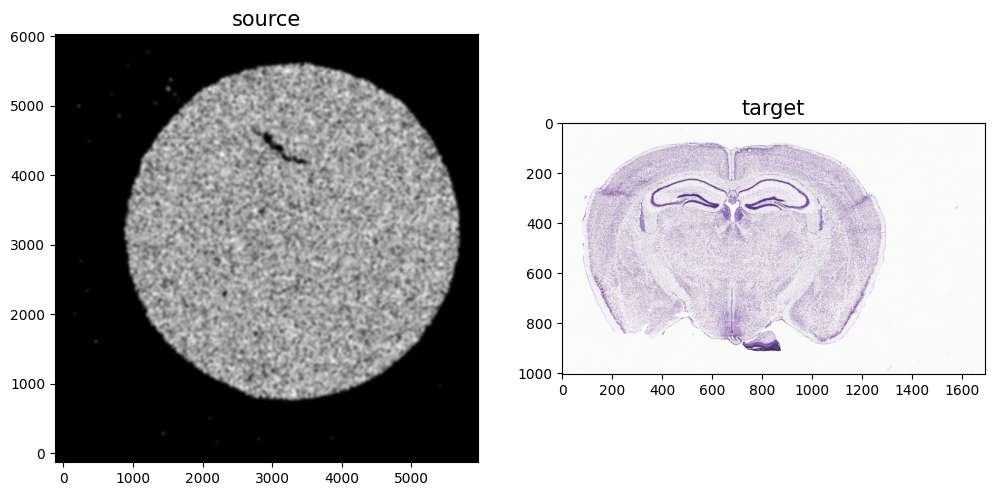

In [14]:
# plot rasterised source and target

# get extent of images
extent_sp = STalign.extent_from_x((spy,spx))
extent_img = STalign.extent_from_x((imgy,imgx))

fig,ax = plt.subplots(1,2)
ax[0].imshow((sp.transpose(1,2,0).squeeze()), extent=extent_sp)
ax[0].invert_yaxis()
ax[0].set_title('source', fontsize=15)
ax[1].imshow((img_t.transpose(1,2,0).squeeze()), extent=extent_img)
ax[1].set_title('target', fontsize=15)

In [15]:
np.savez(work_dir + '/store/merfish', x=spx,y=spy,I=sp)
np.savez(work_dir + '/store/he_60', x=imgx,y=imgy,I=img_t)

In [16]:
#python ./STalign/STalign/point_annotator.py ./store/merfish.npz ./store/he_60.npz # open STalign GUI from bash


In [17]:
# read from file
pointssplist = np.load(work_dir + '/store/merfish_points.npy', allow_pickle=True).tolist()
print(pointssplist)
pointsimglist = np.load(work_dir + '/store/he_60_points.npy', allow_pickle=True).tolist()
print(pointsimglist)


{'blank': [(2738.0523440860215, 4646.247892473119), (3255.832989247312, 4257.91240860215), (3543.488903225807, 4200.381225806452)], 'edge': [(5470.783526881721, 2287.4693978494615), (5657.759870967742, 2834.0156344086017), (1155.9448172043012, 4257.91240860215)]}
{'blank': [(734.0139784946236, 365.57311827956937), (773.9924731182796, 373.56881720430056), (797.9795698924731, 369.57096774193496)], 'edge': [(989.8763440860216, 313.60107526881666), (969.8870967741937, 345.5838709677414), (678.0440860215058, 273.6225806451607)]}


In [18]:
# convert dict to array
pointssp = []
pointsimg = []

for i in pointssplist.keys():
    for j in range(len(pointssplist[i])):
        pointssp.append([pointssplist[i][j][1], pointssplist[i][j][0]])
for i in pointsimglist.keys():
    for j in range(len(pointsimglist[i])):
        pointsimg.append([pointsimglist[i][j][1], pointsimglist[i][j][0]])

pointssp = np.array(pointssp)
pointsimg = np.array(pointsimg)

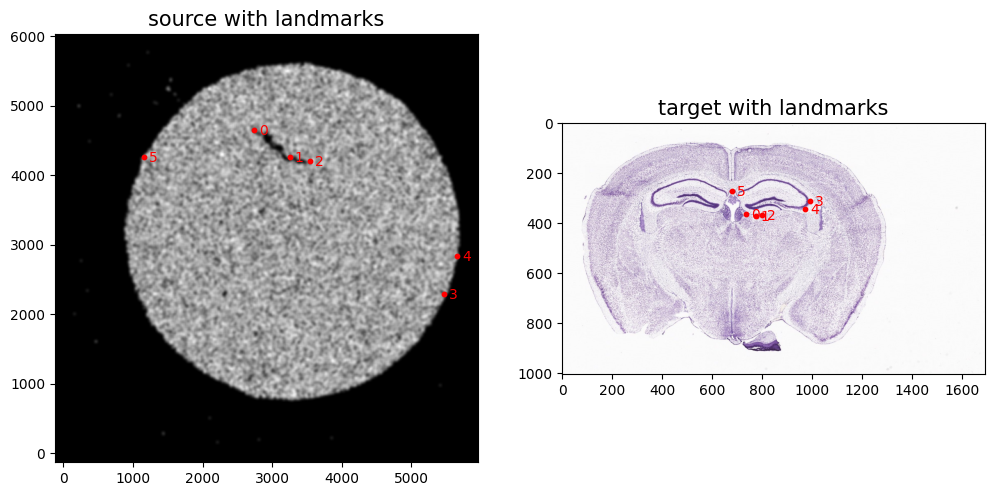

In [19]:
# plot landmarks (part of figure 5)

fig,ax = plt.subplots(1,2)
ax[0].imshow((sp.transpose(1,2,0).squeeze()), extent=extent_sp)
ax[1].imshow((img_t.transpose(1,2,0).squeeze()), extent=extent_img)

trans_offset_0 = mtransforms.offset_copy(ax[0].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')
trans_offset_1 = mtransforms.offset_copy(ax[1].transData, fig=fig,
                                       x=0.05, y=-0.05, units='inches')

ax[0].scatter(pointssp[:,1],pointssp[:,0], c='red', s=10)
ax[1].scatter(pointsimg[:,1],pointsimg[:,0], c='red', s=10)

for i in range(len(pointssp)):
    ax[0].text(pointssp[i][1], pointssp[i][0], f'{i}', c='red', transform=trans_offset_0, fontsize= 10)
for i in range(len(pointsimg)):
    ax[1].text(pointsimg[i][1], pointsimg[i][0], f'{i}', c='red', transform=trans_offset_1, fontsize= 10)

ax[0].set_title('source with landmarks', fontsize=15)
ax[1].set_title('target with landmarks', fontsize=15)

# invert only rasterized image
ax[0].invert_yaxis()

In [20]:
fig.savefig(work_dir + '/store/STalign_landmarks.svg')

In [21]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [22]:
# compute initial affine transformation from points
L,T = STalign.L_T_from_points(pointssp,pointsimg)
A = STalign.to_A(torch.tensor(L),torch.tensor(T))

Text(0.5, 1.0, 'target')

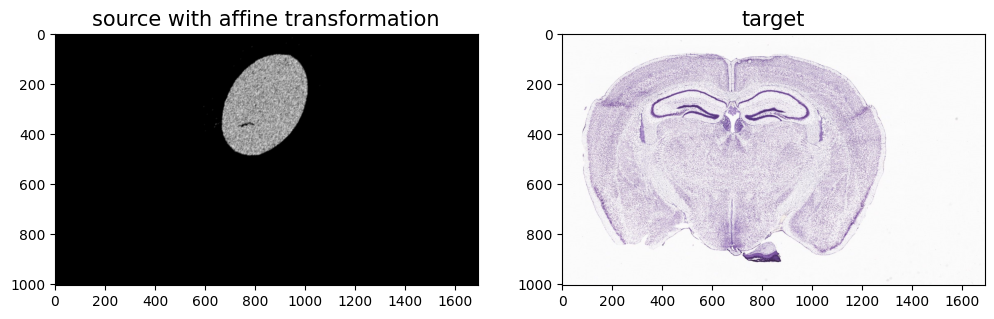

In [23]:
# compute initial affine transformation from points
AI= STalign.transform_image_source_with_A(A, [spy,spx], sp, [imgy,imgx])

#switch tensor from cuda to cpu for plotting with numpy
if AI.is_cuda:
    AI = AI.cpu()

fig,ax = plt.subplots(1,2)

ax[0].imshow((AI.permute(1,2,0).squeeze()), extent=extent_img)
ax[1].imshow((img_t.transpose(1,2,0).squeeze()), extent=extent_img)

ax[0].set_title('source with affine transformation', fontsize=15)
ax[1].set_title('target', fontsize=15)

CPU times: user 5min 45s, sys: 7min 10s, total: 12min 55s
Wall time: 4min 32s


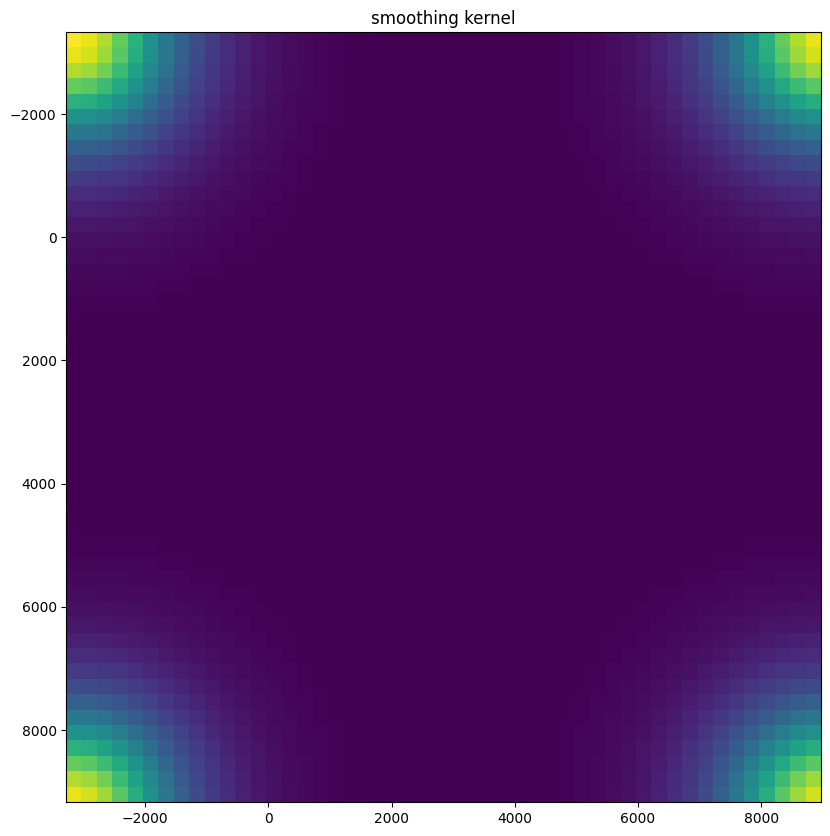

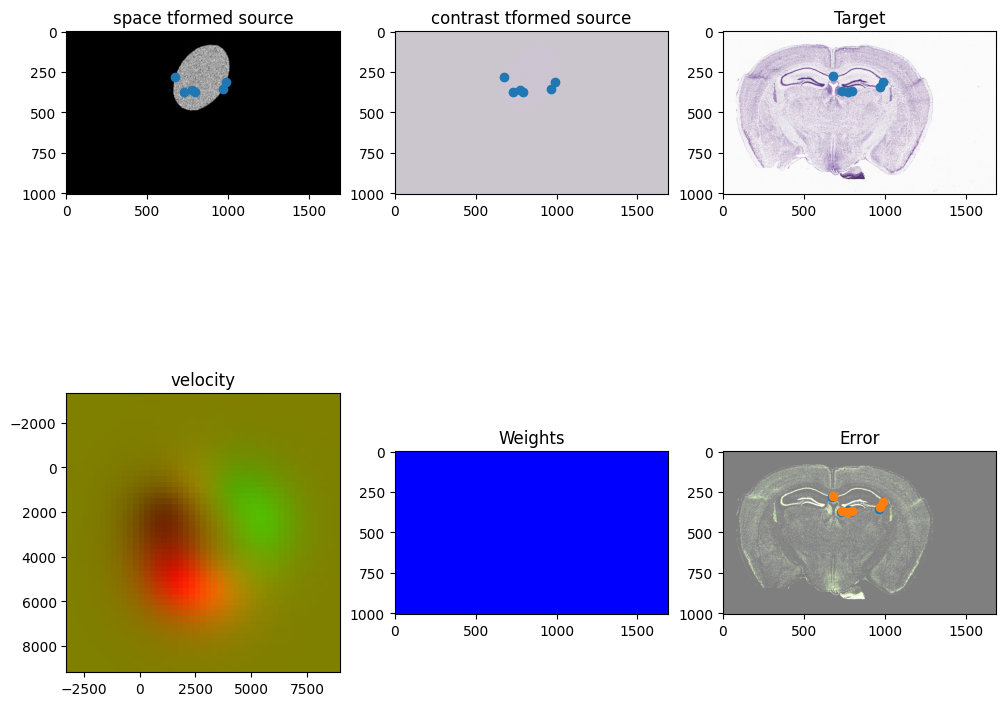

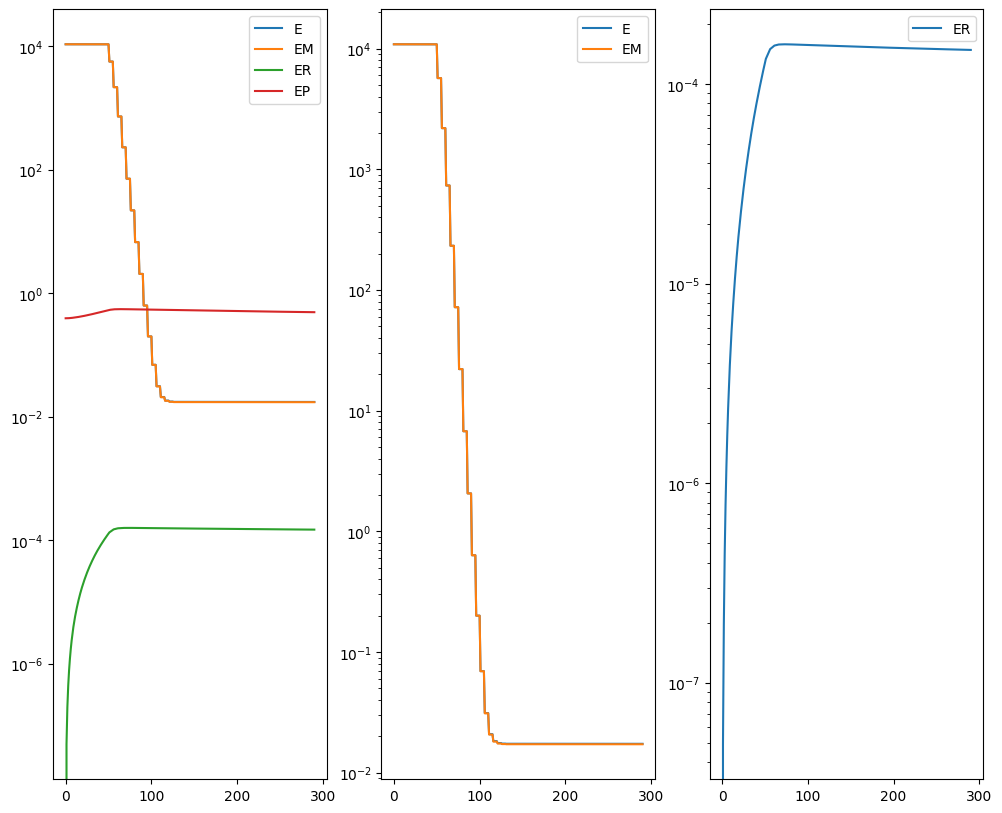

In [24]:
%%time

# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {'L':L,'T':T,
          'niter':300,
          'pointsI':pointssp,
          'pointsJ':pointsimg,
          'device':device,
          'sigmaM':1.5,
          'sigmaB':1.0,
          'sigmaA':1.1,
          'epV': 100
          }

out = STalign.LDDMM([spy,spx],sp,[imgy,imgx],img_t,**params)

In [25]:
#### get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']
WM = out['WM']

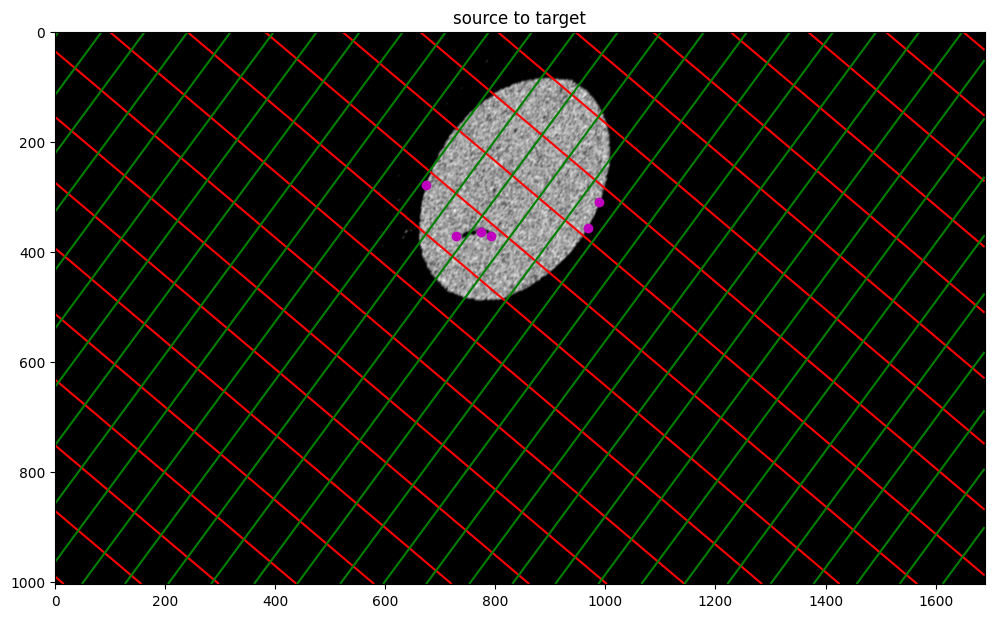

In [26]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[imgy,imgx],direction='b')
phi_sp = STalign.transform_image_source_to_target(xv,v,A,[spy,spx],sp,[imgy,imgx])
phiipointssp = STalign.transform_points_source_to_target(xv,v,A,pointssp)

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phi_sp.is_cuda:
    phi_sp = phi_sp.cpu()
if phiipointssp.is_cuda:
    phiipointssp = phiipointssp.cpu()


# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)

ax.contour(imgx,imgy,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(imgx,imgy,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')

ax.imshow(phi_sp.permute(1,2,0)/torch.max(phi_sp),extent=extent_img)
ax.scatter(phiipointssp[:,1].detach(),phiipointssp[:,0].detach(),c="m")


In [28]:
# apply transform to original points
tpointssp= STalign.transform_points_source_to_target(xv,v,A, np.stack([df['ycoord'], df['xcoord']], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointssp.is_cuda:
    tpointssp = tpointssp.cpu()

# switch from row column coordinates (y,x) to (x,y)
spx_LDDMM = tpointssp[:,1]
spy_LDDMM = tpointssp[:,0]


Text(0.5, 1.0, 'After alignment aligned source and target with aligned pointssp and pointsimg')

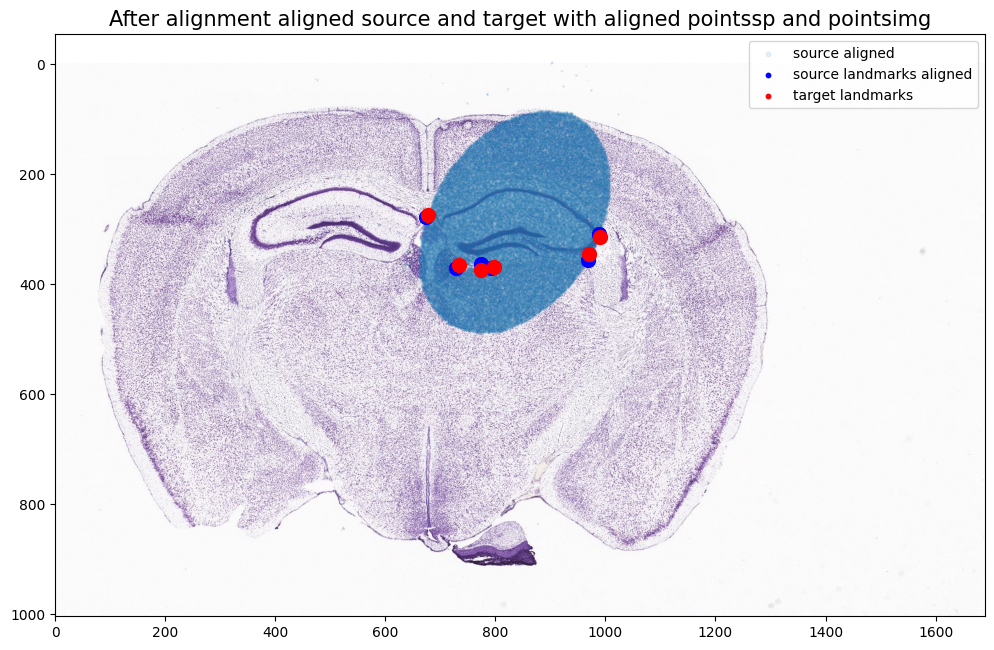

In [29]:
# plot results
fig,ax = plt.subplots()

ax.imshow((img_t).transpose(1,2,0),extent=extent_img)

ax.scatter(spx_LDDMM,spy_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(phiipointssp[:,1].detach(),phiipointssp[:,0].detach(),c="blue", label='source landmarks aligned', s=100)

ax.scatter(pointsimg[:,1],pointsimg[:,0], c='red', label='target landmarks', s=100)
ax.set_aspect('equal')

lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legend_handles:
    handle.set_sizes([10.0])

ax.set_title('After alignment aligned source and target with aligned pointssp and pointsimg', fontsize=15)

In [30]:
if tpointssp.is_cuda:
    df3 = pd.DataFrame({"aligned_x": spx_LDDMM.cpu(), "aligned_y": spy_LDDMM.cpu(),},index=df.index)
else:
    df3 = pd.DataFrame({"aligned_x": spx_LDDMM,"aligned_y": spy_LDDMM,},index=df.index)
    
results = pd.concat([df, df3], axis=1)
results.head()


xcoord  ycoord  cluster  cluster_codes   aligned_x   
0                                                                     
AACGTCATAATCGT   888.95  3219.5     10.0             10  716.959491  \
TACTTTAGCGCAGT  4762.20  5020.4     10.0             10  805.943987   
CATGCCTGGGTTCG   886.50  3199.6     10.0             10  717.919838   
TCGATATGGCACAA  2237.10  5144.6     10.0             10  677.542685   
TTATCTGACGAAGC  1031.80  2425.2     10.0             10  766.876164   

                 aligned_y  
0                           
AACGTCATAATCGT  190.688198  
TACTTTAGCGCAGT  480.937514  
CATGCCTGGGTTCG  189.125747  
TCGATATGGCACAA  387.160688  
TTATCTGACGAAGC  138.135940

In [32]:
results.to_csv(work_dir + '../store/ST_align_result.csv')